In [36]:
import pandas as pd
import xgboost
import shap
import sklearn
from pathlib import Path

# Path to your data file
DATA_PATH = Path("../data/telco_churn.csv")

df = pd.read_csv(DATA_PATH)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [38]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Quick missing check after conversion
df['TotalCharges'].isna().sum()

# Encode target: 1 = churn, 0 = not churn
df['churn'] = (df['Churn'] == 'Yes').astype(int)

if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])


In [39]:
df.isna().sum().sort_values(ascending=False).head(20)

TotalCharges        11
SeniorCitizen        0
Partner              0
Dependents           0
gender               0
tenure               0
PhoneService         0
InternetService      0
MultipleLines        0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
OnlineSecurity       0
StreamingTV          0
StreamingMovies      0
PaperlessBilling     0
Contract             0
PaymentMethod        0
MonthlyCharges       0
Churn                0
dtype: int64

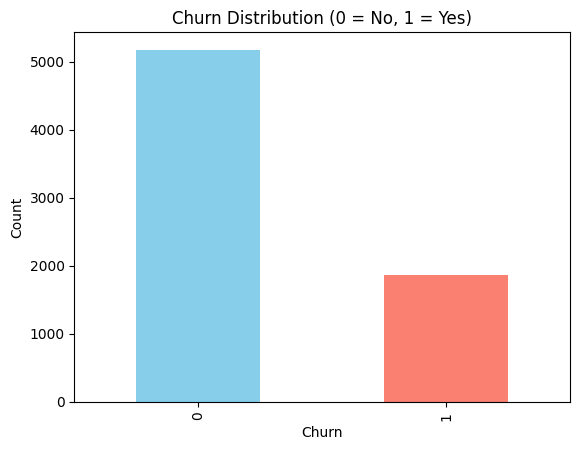

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [40]:
import matplotlib.pyplot as plt

df['churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

df['churn'].value_counts(normalize=True)


In [41]:
def rate(col):
    return (df.groupby(col)['churn'].mean().sort_values(ascending=False))

for c in ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents']:
    if c in df.columns:
        print(f"\nChurn rate by {c}")
        display(rate(c).to_frame('churn_rate').head(10))



Churn rate by Contract


,churn_rate
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319



Churn rate by InternetService


,churn_rate
InternetService,
Fiber optic,0.418928
DSL,0.189591
No,0.074050



Churn rate by PaymentMethod


,churn_rate
PaymentMethod,
Electronic check,0.452854
Mailed check,0.191067
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431



Churn rate by SeniorCitizen


,churn_rate
SeniorCitizen,
1,0.416813
0,0.236062



Churn rate by Partner


,churn_rate
Partner,
No,0.329580
Yes,0.196649



Churn rate by Dependents


,churn_rate
Dependents,
No,0.312791
Yes,0.154502


In [42]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


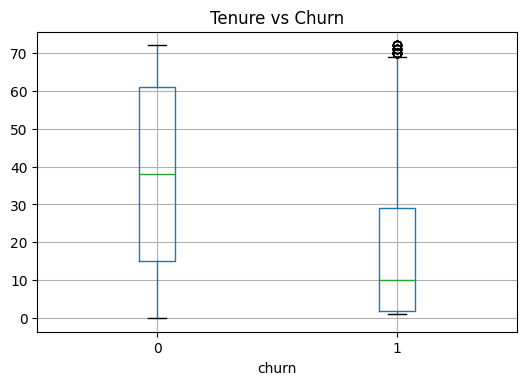

In [43]:
df.boxplot(column='tenure', by='churn', figsize=(6,4))
plt.title("Tenure vs Churn")
plt.suptitle("")
plt.show()


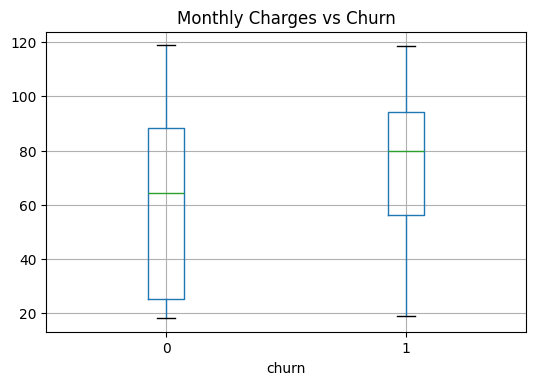

In [44]:
df.boxplot(column='MonthlyCharges', by='churn', figsize=(6,4))
plt.title("Monthly Charges vs Churn")
plt.suptitle("")
plt.show()


In [45]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn', 'Churn']) if 'Churn' in df.columns else df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


In [46]:
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

num_cols, cat_cols


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline  # to avoid name clash

numeric_transformer = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logit_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
])


In [49]:
logit_model.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


[0.1170282  0.85223654 0.14770386 ... 0.33603608 0.01332965 0.01784797]
ROC-AUC: 0.8415278100700094
PR-AUC: 0.6324874843771376
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



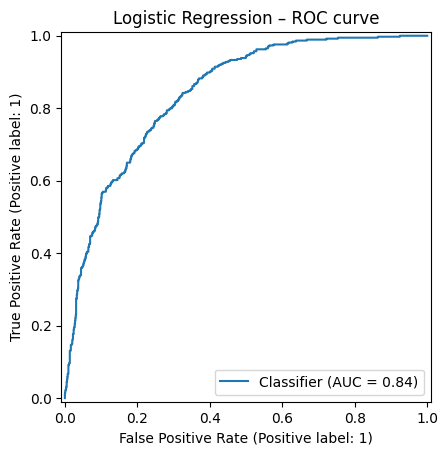

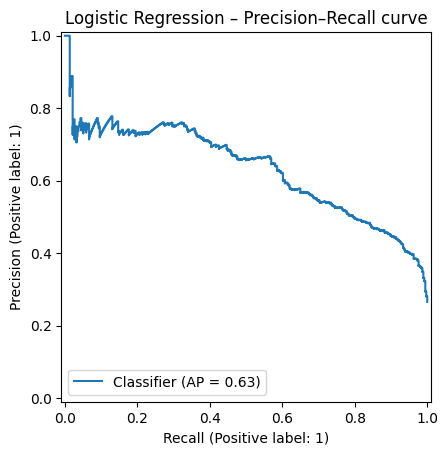

In [51]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Probabilities for class 1 (churn)
y_proba = logit_model.predict_proba(X_test)[:, 1]
print(y_proba)

# Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

# Using default 0.5 threshold just to inspect
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Logistic Regression – ROC curve")
plt.show()

# Precision–Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Logistic Regression – Precision–Recall curve")
plt.show()



In [52]:
from xgboost import XGBClassifier
xgb_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric='logloss',
        tree_method='hist'
    ))
])

xgb_model.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


ROC-AUC: 0.8364088454881293
PR-AUC: 0.6459434852378494


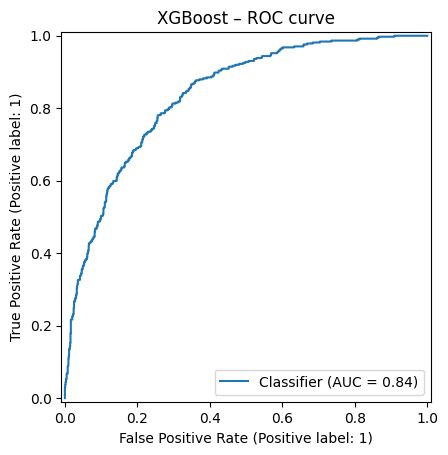

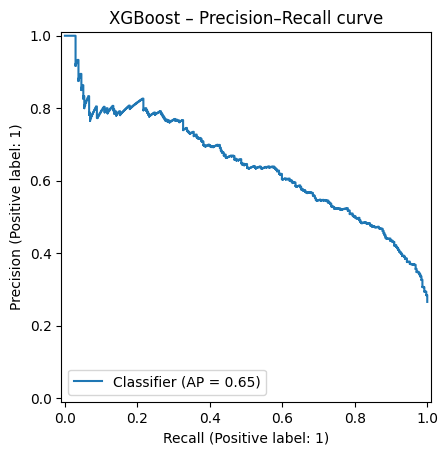

In [53]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR-AUC:", average_precision_score(y_test, y_proba_xgb))

RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("XGBoost – ROC curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_xgb)
plt.title("XGBoost – Precision–Recall curve")
plt.show()


In [54]:
from sklearn.metrics import fbeta_score
import numpy as np

def best_threshold(y_true, y_scores, beta=2.0):
    # Generate many possible thresholds between 0.05 and 0.95
    ths = np.linspace(0.05, 0.95, 181)  # step of 0.005
    
    # For each threshold, convert probabilities to 0/1 and compute the F-beta score
    fs = []
    for t in ths:
        y_pred = (y_scores >= t).astype(int)
        f = fbeta_score(y_true, y_pred, beta=beta)
        fs.append(f)
    
    # Find the threshold that gives the highest F-beta
    best_idx = int(np.argmax(fs))
    return ths[best_idx], fs[best_idx]

thr, f2 = best_threshold(y_test, y_proba_xgb, beta=2.0)
thr, f2


(np.float64(0.14999999999999997), 0.744874715261959)

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_opt = (y_proba_xgb >= thr).astype(int)

print("Chosen threshold:", round(thr, 3))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_opt))
print("\nClassification report:")
print(classification_report(y_test, y_pred_opt, digits=4))


Chosen threshold: 0.15
Confusion matrix:
[[663 372]
 [ 47 327]]

Classification report:
              precision    recall  f1-score   support

           0     0.9338    0.6406    0.7599      1035
           1     0.4678    0.8743    0.6095       374

    accuracy                         0.7026      1409
   macro avg     0.7008    0.7575    0.6847      1409
weighted avg     0.8101    0.7026    0.7200      1409



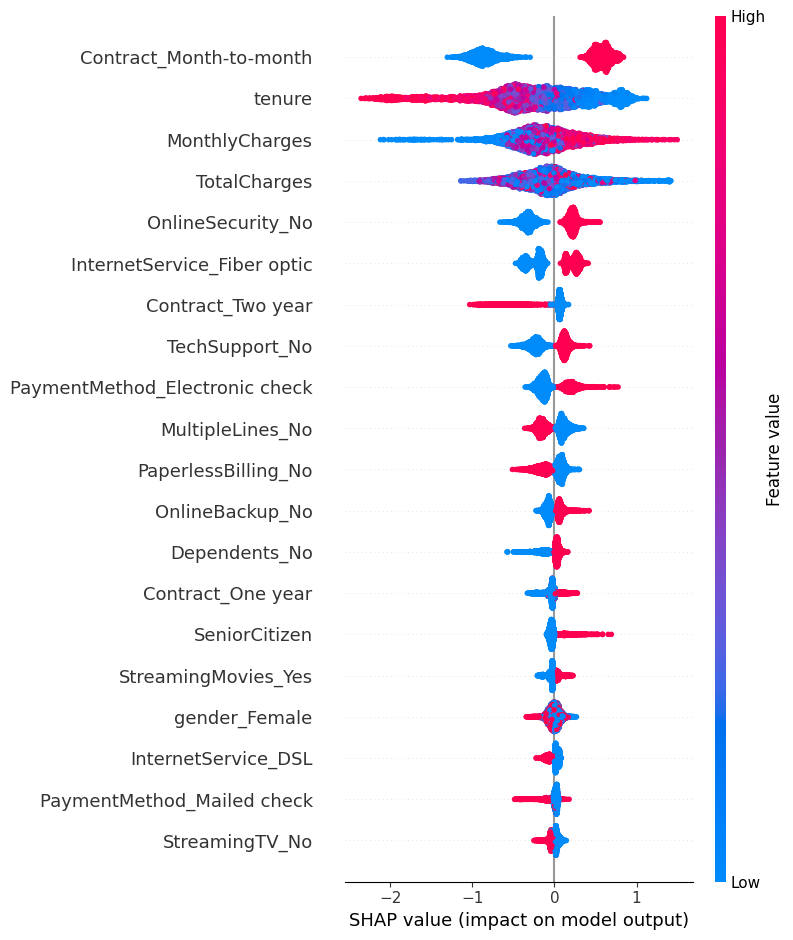

In [57]:
import shap

# Extract the trained preprocessing and model
fitted_preprocess = xgb_model.named_steps['prep']
fitted_xgb = xgb_model.named_steps['clf']

# Get feature names after one-hot encoding
ohe = fitted_preprocess.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = ohe.get_feature_names_out(fitted_preprocess.transformers_[1][2])
num_feature_names = fitted_preprocess.transformers_[0][2]

feature_names = list(num_feature_names) + list(cat_feature_names)

# Transform X_train for SHAP
X_train_transformed = fitted_preprocess.transform(X_train)

explainer = shap.TreeExplainer(fitted_xgb)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


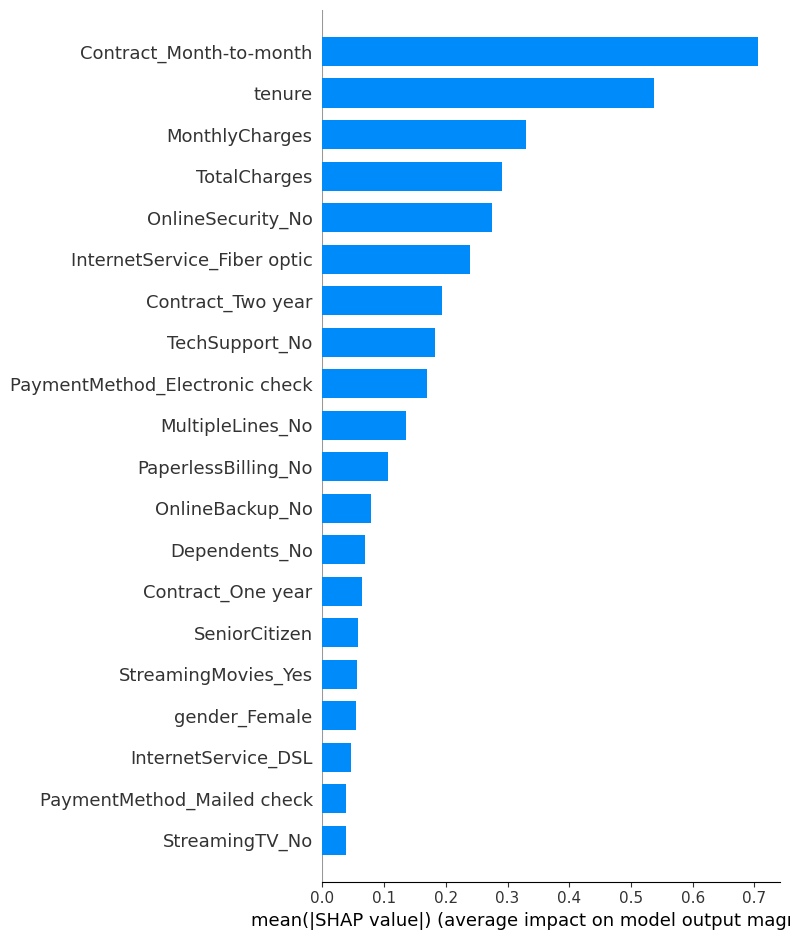

In [58]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")


In [59]:
import joblib
import json
from pathlib import Path
from datetime import datetime

MODEL_PATH = Path("../models/xgb_churn_pipeline.pkl")
META_PATH = Path("../models/metadata.json")

# Save the trained model pipeline
joblib.dump(xgb_model, MODEL_PATH)

# Save metadata (threshold + metrics + feature names)
meta = {
    "created_at": datetime.now().isoformat(timespec='seconds'),
    "threshold": float(thr),
    "metrics": {
        "roc_auc": float(roc_auc_score(y_test, y_proba_xgb)),
        "pr_auc": float(average_precision_score(y_test, y_proba_xgb))
    },
    "feature_names_after_encoding": list(feature_names)
}

META_PATH.write_text(json.dumps(meta, indent=4))



Saved model and metadata!
